<a href="https://colab.research.google.com/github/juanflorezVe/COMP9058_lab1/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Copying the code from the assignment
import tensorflow as tf
print(tf.__version__)
experiment = tf.Variable([1,2,3])
print(tf.divide(tf.reduce_sum(experiment),experiment.shape[0]))

2.4.1
tf.Tensor(2.0, shape=(), dtype=float64)


x_train shape (60000, 784), x_test shape (10000, 784)
x_trNoisy shape (60000, 784), x_teNoisy shape (10000, 784)


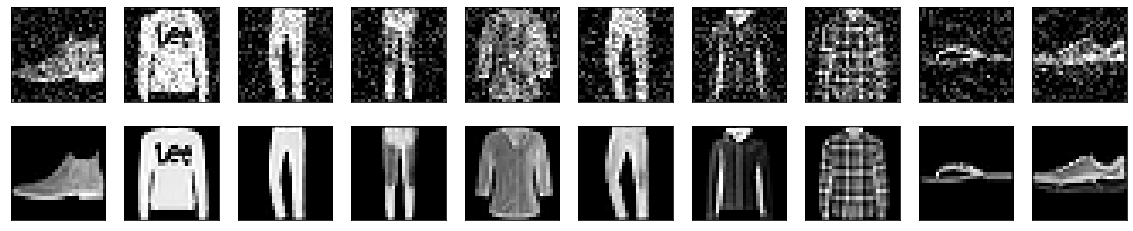

tr_x (60000, 784), te_x (10000, 784), tr_xn (60000, 784), te_xn (10000, 784)


In [17]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
def main():

  (x_train, _), (x_test, _) = fashion_mnist.load_data()
  # Normalize train and test data
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.

  # Reshape so that each instance is a linear array of 784 normalized pixel values
  x_train = x_train.reshape((len(x_train), 784))
  x_test = x_test.reshape((len(x_test), 784))
  print ("x_train shape {}, x_test shape {}".format(x_train.shape, x_test.shape))

  # Add random noise to the image
  noise_factor = 0.2
  x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
  x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

  # Clip the resulting values so that they don't fall outside the upper and lower normalized value of 0 and 1
  x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
  x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

  print ("x_trNoisy shape {}, x_teNoisy shape {}".format(x_train_noisy.shape, x_test_noisy.shape))
  n = 10  # Number of images to display 

  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test_noisy[i].numpy().reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()
  return x_train, x_test, x_train_noisy, x_test_noisy
tr_x, te_x, tr_xn, te_xn = main()
print("tr_x {}, te_x {}, tr_xn {}, te_xn {}".format(
                                              tr_x.shape, 
                                              te_x.shape, 
                                              tr_xn.shape,
                                              te_xn.shape))

In [45]:
#Let's insert 784 parameters to each neuron
# A = W.T * X + b
# layer_pass will take the x matrix, pass it to the l layer applying the w weights and adding the b bias
#NeuralNetworksW5 slide 11
# m = 60000
# n = 784
# p = 200
def relu_layer_pass(w, x, b):
  t = tf.matmul(w,x)
  l = tf.add(t,b)
  h = tf.keras.activations.relu(l)
  return h

def softmax_layer_pass(w, x, b):
  t = tf.matmul(w,x)
  l = tf.add(t,b)
  l_exp = tf.math.exp(l)
  sums = tf.reduce_sum(l_exp,0)
  h = l_exp/sums
  return h

def sigmoid_layer_pass(w, x, b):
  t = tf.matmul(w, x)
  l = tf.add(t, b)
  h = 1/(1+tf.math.exp(-l))
  return h
  

def dropoutLayer(rows, cols, dropOutProb):
  ''' Inspiration from slide 51 NeuroNetworksW5.pdf
  '''
  if dropOutProb < 0 or dropOutProb > 100:
    dropOutProb = 1
  if dropOutProb >= 1 and dropOutProb < 100:
    dropOutProb /= 100
  
  probThreshold = 1 - dropOutProb
  dropTensor = tf.Variable(tf.random.uniform(shape=[rows,cols], dtype=tf.float32) < probThreshold)
  dropTensor = tf.cast(dropTensor, tf.float32)
  return dropTensor



In [46]:
#test sigmoid
xst = tf.Variable([[ 10, -10,   0],
                   [-100,  0, 120],
                   [-30, -40,  50]], dtype= tf.float32, shape = [3,3])
wst = tf.Variable([[1, 1, 1],
                   [2, 2, 2],
                   [3, 3, 3]], dtype = tf.float32, shape = [3,3])
bst = tf.Variable([[0],[0],[0]], dtype = tf.float32, shape = [3,1])
sig = sigmoid_layer_pass(wst, xst, bst)
sig

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.0000000e+00, 1.9287501e-22, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)>

In [47]:
#Test dropout layer:
tdp = dropoutLayer(10,10, 0.50)
print(tf.reduce_sum(tdp))
tdp

tf.Tensor(57.0, shape=(), dtype=float32)


<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 1., 1., 1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [1., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 1., 1., 0.],
       [0., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
       [1., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [60]:
def S_forward_pass(w1,  w6, b1, b6, x):
  dropOutP = 0.03
  #pass the first layer
  h1 = relu_layer_pass(w1,x,b1)
  #pass the sixth layer
  h6 = sigmoid_layer_pass(w6, h1, b6)
  return h6


def cross_entropy(expected, predicted):
  #Assumes predicted was produced by sigmod
  fullmatrix = ((expected -predicted)**2)
  means = tf.reduce_mean(fullmatrix, 0) # the row with each mean error for each training instance
  return (means)
  #prediction = tf.math.log(predicted/(1-predicted))
  #return tf.keras.losses.MSE(expected, predicted)

def calculate_accuracy(predicted, expected):
  #Inspiered from slide 48 of tensorFlow and Keras lecture notes (Without rounding)
  predictions = tf.round(predicted)
  expected = expected
  correctones = tf.cast(tf.equal(predictions, expected), tf.float32)
  accuracy = tf.reduce_mean(correctones)
  return accuracy

Question 1, section a. Question1_2_1 (dropout)


In [61]:
# from lecture (VectorizedLogistiRegression, page 50) March 9th.... 
# We have a set of trainning of 60000 rows (instances)
# and 748 columns ( Features)
# Our X vector has 784 rows (as fetarues) and 60000 columns (instances)
X = tf.transpose(tr_xn)
X = tf.cast(X, tf.float32)
#print("The second dirty instance is {}".format(X[:,2])) # print the second instance
#print("X shape is {}".format( X.shape))
# our target values (tr_y) will be the  "clean" X
tr_y = tf.transpose(tr_x)
tr_y = tf.cast(tr_y, tf.float32)
#print("tr_y shape is {}".format(tr_y.shape))
#print("The second clean instance is {}".format(tr_y[:,2])) # print the second instance
# Let's create a vector W1 with the number of weights (784) for each neuron in one row
# so, it means 128 rows and 784 columns ( Features) for layer 1
W1 = tf.Variable(tf.random.normal([128,784], mean=0.0, stddev=0.01))
#The bias for the first layer of 128 neurons will be a vecoter of 200 rows (1 per neuron)
# and 1 column
B1 = tf.Variable(tf.random.uniform(shape=[128,1],dtype=tf.float32))

print ("W1 shape is{}".format(W1.shape))
print ("B1 shape is{}".format(B1.shape))

W1 shape is(128, 784)
B1 shape is(128, 1)


In [62]:
#The second layer:
# W2 has 100 rows (as it has 100 neurones)
W2 = tf.Variable(tf.random.normal(shape=[64,128], mean=0.0, stddev=0.07))
B2 = tf.Variable(tf.random.uniform(shape=[64,1], dtype=tf.float32))
print ("W2 shape is{}".format(W2.shape))
print ("B2 shape is{}".format(B2.shape))

W2 shape is(64, 128)
B2 shape is(64, 1)


In [63]:
#The third layer:
# W3 has 10 rows (as it has 10 clases)
W3 = tf.Variable(tf.random.normal(shape=[32,64], mean=1.0, stddev=0.03))
B3 = tf.Variable(tf.random.uniform(shape=[32,1], dtype=tf.float32))
print ("W3 shape is{}".format(W3.shape))
print ("B3 shape is{}".format(B3.shape))

W3 shape is(32, 64)
B3 shape is(32, 1)


In [64]:
#The fourth layer:
# W4 has 64 rows 
W4 = tf.Variable(tf.random.normal(shape=[64,32], mean=1.0, stddev=0.07))
B4 = tf.Variable(tf.random.uniform(shape=[64,1], dtype=tf.float32))
print ("W4 shape is{}".format(W4.shape))
print ("B4 shape is{}".format(B4.shape))

W4 shape is(64, 32)
B4 shape is(64, 1)


In [65]:
#The fifth layer:
# W5 has 10 rows (as it has 10 clases)
W5 = tf.Variable(tf.random.normal(shape=[128,64], mean=0.0, stddev=0.05))
B5 = tf.Variable(tf.random.uniform(shape=[128,1], dtype=tf.float32))
print ("W5 shape is{}".format(W5.shape))
print ("B5 shape is{}".format(B5.shape))

W5 shape is(128, 64)
B5 shape is(128, 1)


In [66]:
#The sixth layer:
# W6 has 10 rows (as it has 10 clases)
W6 = tf.Variable(tf.random.normal(shape=[784,128],  mean=0.0, stddev=0.05))
B6 = tf.Variable(tf.random.uniform(shape=[784,1], dtype=tf.float32))
print ("W6 shape is{}".format(W6.shape))
print ("B6 shape is{}".format(B6.shape))

W6 shape is(784, 128)
B6 shape is(784, 1)


In [67]:
learning_rate=0.04
iterations=100
adam_optimizer=tf.keras.optimizers.Adam()
plt_iter = []
plt_error = []
plt_accur = []

In [69]:
# Rgression loop
for i in range(iterations):
    with tf.GradientTape() as tape:
      H = S_forward_pass(W1, W6, B1, B6, X)
      loss = cross_entropy(tr_y, H)
      print("the loss shape {}".format(loss.shape))
    gradients = tape.gradient(loss,[W1,W6,B1,B6])
    accuracy = calculate_accuracy(H, tr_y)
  
    E = cross_entropy(tr_y,H)
    plt_iter.append(i)
    meanE = tf.reduce_sum(E)
    plt_error.append(tf.reduce_sum(E)*5) 
    print("in Iteration {}, E value is {}, Accuracy is {}".format(i, meanE, accuracy))
    plt_accur.append(accuracy)
    adam_optimizer.apply_gradients(zip(gradients, [W1,W6,B1,B6]))
    
print("Done") 


the loss shape (60000,)
in Iteration 0, E value is 12107.71484375, Accuracy is 0.1837385594844818
the loss shape (60000,)
in Iteration 1, E value is 11536.87890625, Accuracy is 0.2226967066526413
the loss shape (60000,)
in Iteration 2, E value is 10803.99609375, Accuracy is 0.2720796763896942
the loss shape (60000,)
in Iteration 3, E value is 10003.91796875, Accuracy is 0.3182868957519531
the loss shape (60000,)
in Iteration 4, E value is 9209.76953125, Accuracy is 0.36238300800323486
the loss shape (60000,)
in Iteration 5, E value is 8471.291015625, Accuracy is 0.3975665867328644
the loss shape (60000,)
in Iteration 6, E value is 7823.4111328125, Accuracy is 0.4252761900424957
the loss shape (60000,)
in Iteration 7, E value is 7283.28857421875, Accuracy is 0.4452304542064667
the loss shape (60000,)
in Iteration 8, E value is 6851.6875, Accuracy is 0.4595637023448944
the loss shape (60000,)
in Iteration 9, E value is 6519.087890625, Accuracy is 0.4682907164096832
the loss shape (60000,

In [70]:
test_X = tf.transpose(te_xn)
test_X = tf.cast(test_X, tf.float32)
test_Y = tf.transpose(te_x)
test_Y = tf.cast(test_Y, tf.float32)
realTest = S_forward_pass(W1, W6, B1,B6, test_X)
testAccuracy = calculate_accuracy(realTest, test_Y)
print("Test Accuracy {}".format(testAccuracy))

Test Accuracy 0.49984362721443176


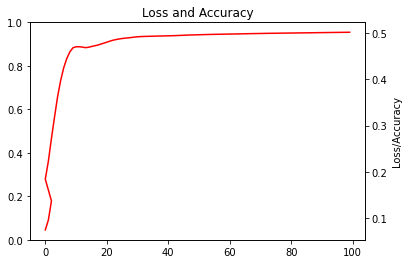

In [71]:
# Display results
import matplotlib.pyplot as plt
ax = plt.gca()

#ax.plot(plt_iter, plt_error)
ax2 = ax.twinx()
ax2.plot(plt_iter, plt_accur, '-r')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Iteration')
plt.ylabel('Loss/Accuracy')
plt.title('Loss and Accuracy')
plt.axis('tight')
plt.show()

(784, 10000)
(784, 10000)
(784, 10000)


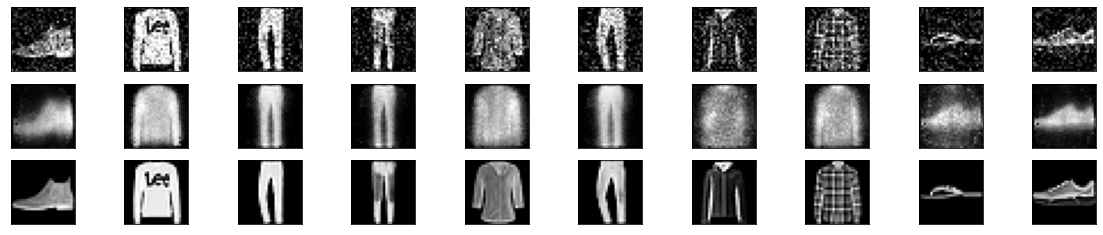

In [72]:
print(realTest.shape)
print(test_X.shape)
print(test_Y.shape)
# display the instance from the dirty set, vs the produced instance
def showEncoded(sent, produced, expected):
  n = 10  # Number of images to display 

  plt.figure(figsize=(20, 4))
  for i in range(n):
    # Display sent
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(sent[:,i].numpy().reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display produced
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(produced[:,i].numpy().reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display expected
      ax = plt.subplot(3, n, i +1 + 2*n)
      plt.imshow(expected[:,i].numpy().reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()
showEncoded(test_X, realTest, test_Y)




In [41]:
tf.equal(realTest[:,0],realTest[:,2])

NameError: ignored

In [22]:
# implementing  slide 31 of NeuralNetworks5
A = tf.Variable([[ 6],
                 [-2], 
                 [ 3]], shape=[3,1],  dtype = tf.float32)
t = tf.math.exp(A)
t

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[4.0342880e+02],
       [1.3533528e-01],
       [2.0085537e+01]], dtype=float32)>

In [ ]:
sum = tf.reduce_sum(t)
sum

In [ ]:
htest = t/sum
htest

In [ ]:
totalTest = tf.reduce_sum(htest)
totalTest # Should be "almost ONE"

<tf.Tensor: shape=(), dtype=float32, numpy=0.99999994>

In [ ]:
# Slide 36, calculate the loss function for softmax
t_expe = tf.Variable([[1.0],
                      [0.0],
                      [0.0]], shape=[3,1])
log_pr = tf.math.log(htest)
log_pr

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.04890689],
       [-8.048907  ],
       [-3.048907  ]], dtype=float32)>

In [ ]:
res = tf.matmul(tf.transpose(t_expe),-log_pr)
res

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04890689]], dtype=float32)>

In [ ]:
#Unit test for loss_function
assert(tf.equal(cross_entropy(t_expe, htest),res))


AssertionError: ignored